In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import to_categorical

# 1.Describe Data
The code begins by loading the dataset `bank-full.csv` into a Pandas DataFrame using `pd.read_csv`, specifying a semicolon (`;`) as the delimiter since the file uses this separator instead of the default comma. Next, it prints the shape of the dataset using `df.shape`, which provides the number of rows and columns, helping to understand the dataset's size and manageability for analysis or modeling. The `df.head()` function is then used to display the first five rows, giving a quick overview of the column names, example values, and whether the data appears clean. The code also checks the data types of each column with `df.dtypes`, which is essential for understanding which columns are numerical, categorical, or object types. Finally, it checks for missing values in each column using `df.isna().sum()`, allowing us to identify potential data cleaning needs before further analysis.


In [2]:
df = pd.read_csv('bank-full.csv', sep=';') 
# Shape of the dataset
print("Dataset shape:", df.shape)  # (rows, columns)

# Display first 5 rows
print("\nFirst 5 rows:")
print(df.head())

# Check column data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

Dataset shape: (45211, 17)

First 5 rows:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Data types:
age           int64
job          object
marital      obj

# 2.Analyze Data

## 1. Target variable distribution
This code snippet creates a visualization to explore the distribution of the target variable `y` in the dataset. First, `plt.figure(figsize=(5,4))` sets the size of the plot to 5 inches wide and 4 inches tall. Then, `sns.countplot(x='y', data=df)` from the Seaborn library generates a bar chart showing the count of each category in the `y` column, which represents whether a customer subscribed to the product or not. The plot is further customized with a title `"Target variable distribution (y)"` and labeled axes `"Subscribed"` for the x-axis and `"Count"` for the y-axis. Finally, `plt.show()` renders the chart. This visualization provides a clear understanding of class balance in the target variable, which is important for modeling decisions.


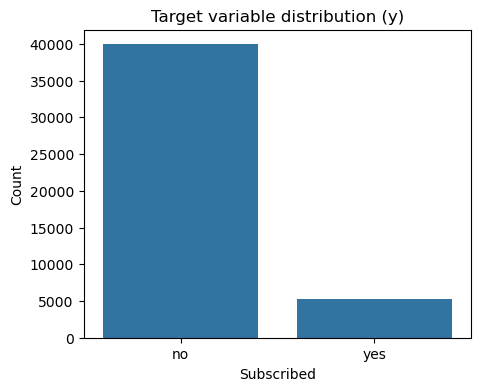

In [8]:
plt.figure(figsize=(5,4))
sns.countplot(x='y', data=df)
plt.title("Target variable distribution (y)")
plt.xlabel("Subscribed")
plt.ylabel("Count")
plt.show()

## 2. Numeric features distribution
This code is used to explore the distribution of all numeric features in the dataset. First, `df.select_dtypes(include=['int64', 'float64']).columns` identifies all columns with numeric data types (integers and floats) and stores their names in `numeric_cols`. Then, `df[numeric_cols].hist(figsize=(15,10), bins=20)` generates histograms for each numeric column, arranging them in a grid layout with a figure size of 15 by 10 inches and dividing the data into 20 bins for more detailed distribution visualization. `plt.suptitle("Numeric Features Distribution")` adds a main title to the figure, and `plt.show()` displays the plots. This approach helps to quickly understand the range, central tendency, and spread of all numeric features in the dataset, as well as to identify any skewness or outliers.


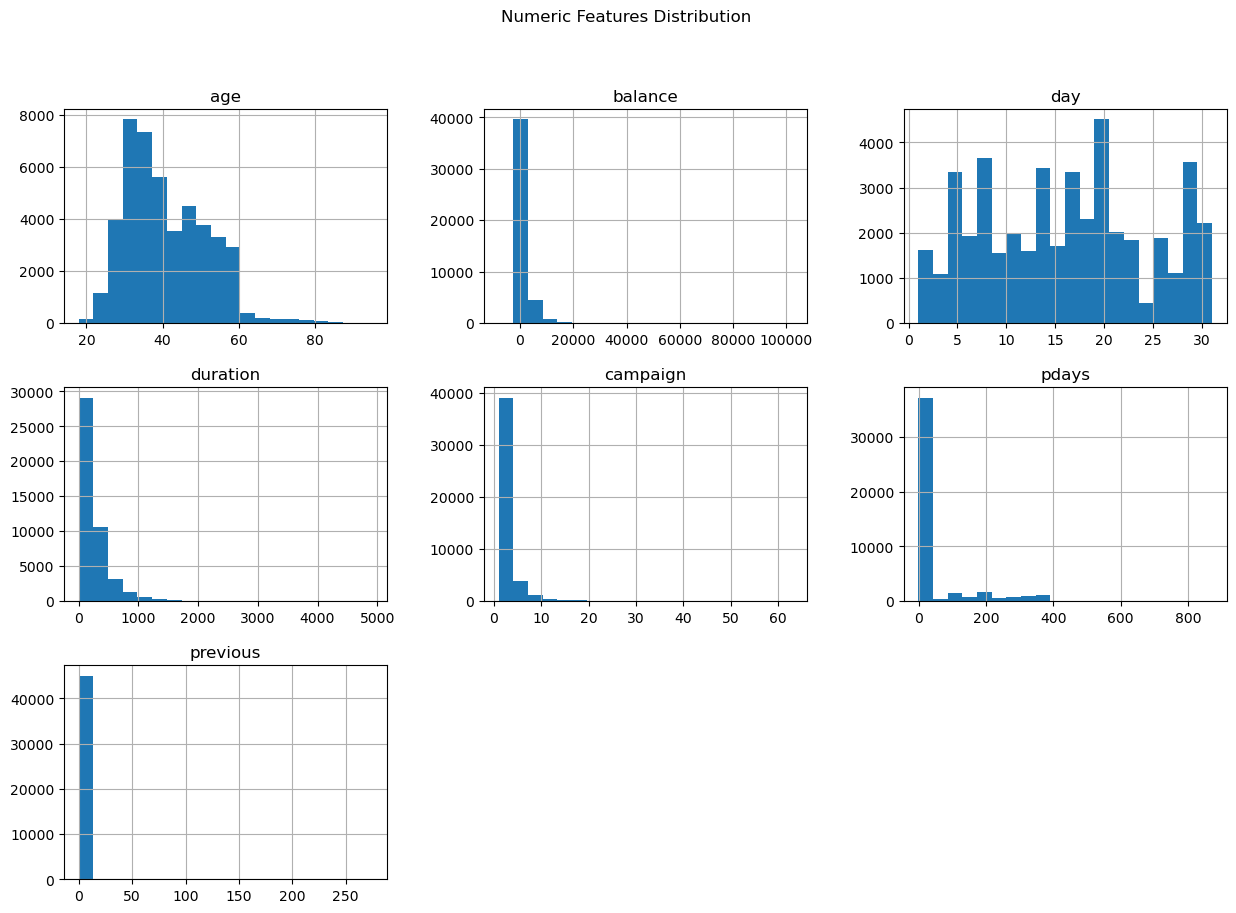

In [9]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15,10), bins=20)
plt.suptitle("Numeric Features Distribution")
plt.show()

## 3.Categorical features distribution (top 5 most frequent categories)
This code is used to analyze the distribution of categorical features in the dataset. First, `df.select_dtypes(include=['object']).columns.drop('y')` selects all columns with object (categorical) data types, excluding the target variable `y`, and stores them in `categorical_cols`. Then, for each categorical column, a separate bar plot is created using Seaborn's `countplot`. The `order=df[col].value_counts().index` argument ensures that the bars are sorted by descending frequency. Each plot has a size of 6 by 4 inches, a title indicating which column is being visualized, and x-axis labels rotated by 45 degrees for better readability. Finally, `plt.show()` displays the plot. This visualization provides a clear view of the frequency distribution for each categorical feature, helping to identify dominant categories, imbalances, or unusual patterns.


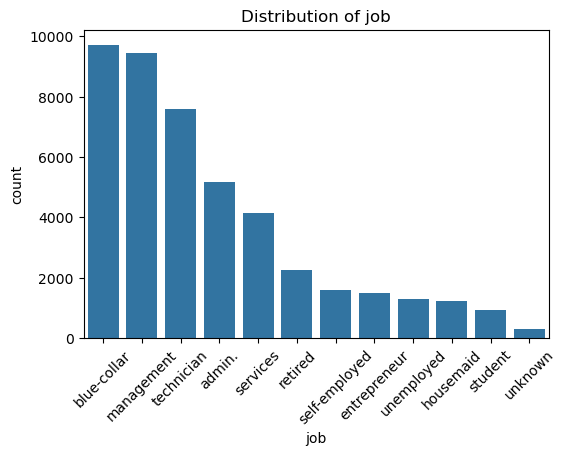

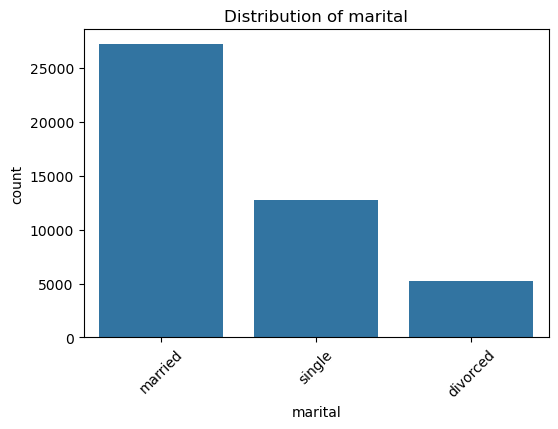

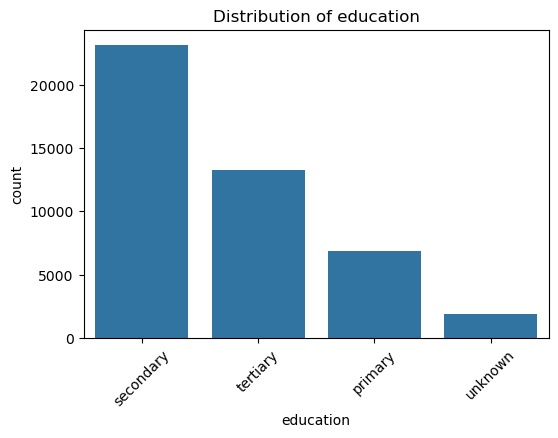

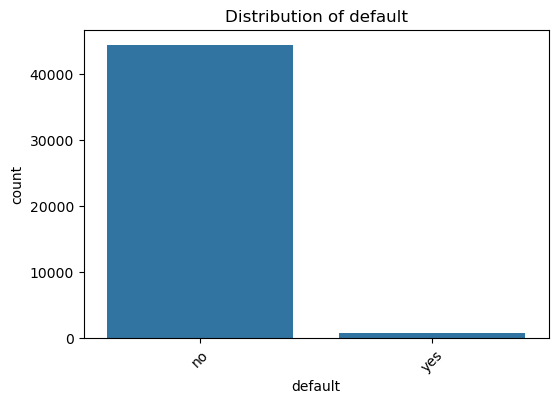

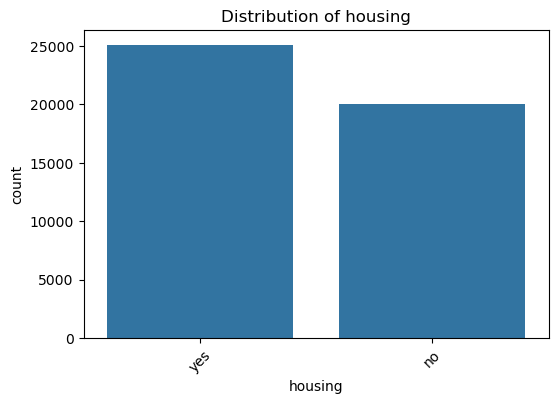

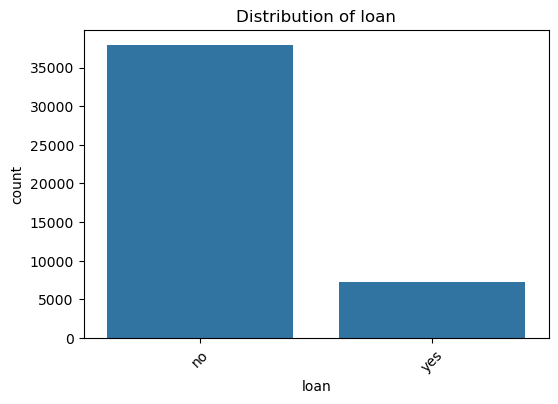

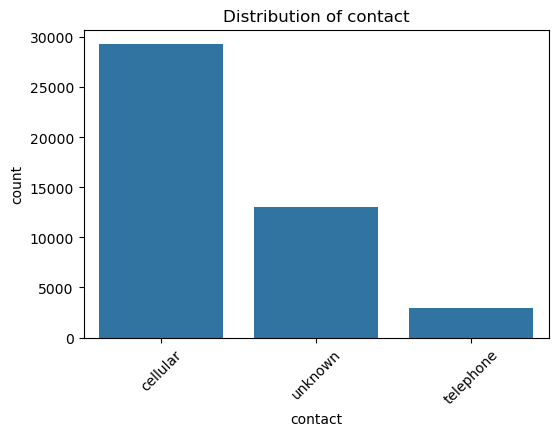

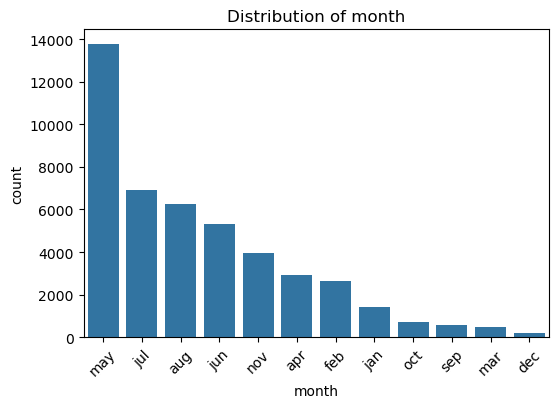

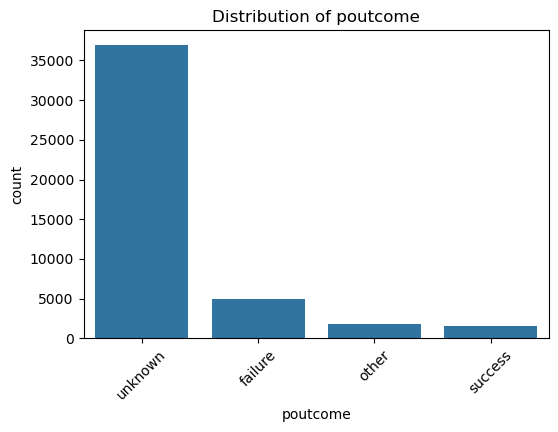

In [10]:
categorical_cols = df.select_dtypes(include=['object']).columns.drop('y')

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

## 4.Correlation matrix for numeric features
This code generates a heatmap to visualize the correlations between numeric features in the dataset. First, `df[numeric_cols].corr()` calculates the pairwise correlation coefficients for all numeric columns, resulting in a correlation matrix. `plt.figure(figsize=(10,8))` sets the plot size to 10 by 8 inches. Then, `sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')` from Seaborn creates a heatmap of the correlation matrix, where `annot=True` displays the correlation values on the cells, and `cmap='coolwarm'` applies a color gradient from cool (negative correlation) to warm (positive correlation). `plt.title("Correlation Matrix (numeric features)")` adds a descriptive title, and `plt.show()` renders the plot. This visualization helps to quickly identify strong positive or negative correlations between numeric features, which can inform feature selection or multicollinearity considerations for modeling.


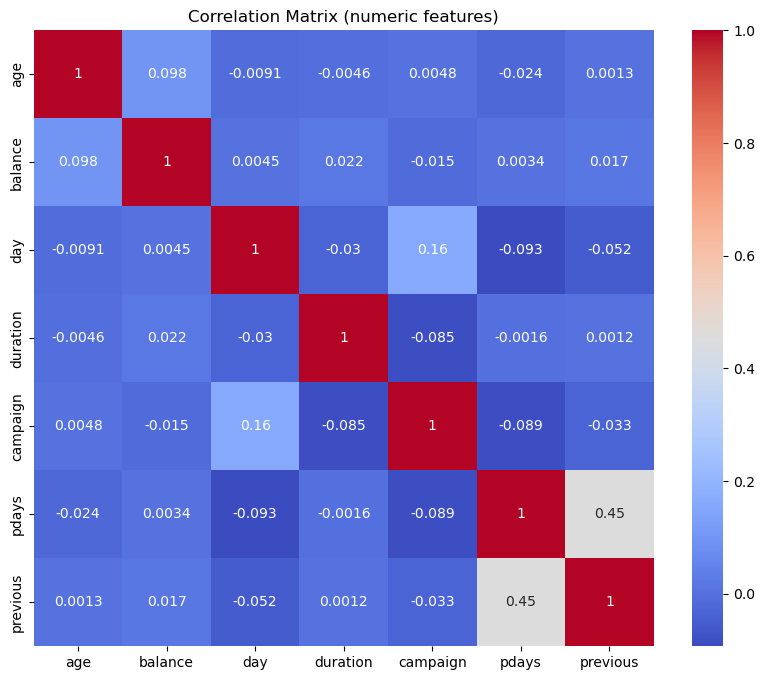

In [11]:
plt.figure(figsize=(10,8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (numeric features)")
plt.show()

# Preprocessing the data 
This code performs the preprocessing steps needed to prepare the dataset for machine learning modeling:

1. **Encode the target variable:**
   Using `LabelEncoder`, the target column `y` is converted from categorical text (`'yes'`/`'no'`) to numeric labels (`1` for yes, `0` for no). This is necessary because most ML models require numeric targets.

2. **Separate features and target:**
   The dataset is split into features `X` (all columns except `y`) and target `y` (the encoded target variable).

3. **One-hot encode categorical features:**
   Categorical columns in `X` are selected, and `OneHotEncoder` is applied to convert them into binary indicator columns. The `drop='first'` parameter avoids multicollinearity by dropping the first category in each column, and `sparse_output=False` ensures the result is a dense NumPy array.

4. **Scale numeric features:**
   Numeric columns are standardized using `StandardScaler`, which rescales the features to have a mean of 0 and standard deviation of 1. This step improves model convergence and ensures all numeric features are on a similar scale.

5. **Combine processed features:**
   The scaled numeric features (`X_num`) and one-hot encoded categorical features (`X_cat`) are horizontally stacked into a single array `X_processed` suitable for model training.

6. **Train/test split:**
   The processed dataset is split into training and testing sets using `train_test_split`, with 20% of the data reserved for testing. The `stratify=y` parameter ensures that the proportion of classes in the target variable is maintained in both sets, preventing class imbalance issues during evaluation.

This preprocessing pipeline ensures that all features are numeric, scaled, and ready for machine learning algorithms.


In [14]:
# 1. Encode target variable
label_enc = LabelEncoder()
df['y'] = label_enc.fit_transform(df['y'])  # yes=1, no=0

# 2. Separate features and target
X = df.drop('y', axis=1)
y = df['y']

# 3. One-hot encode categorical features
cat_cols = X.select_dtypes(include=['object']).columns
ohe = OneHotEncoder(drop='first', sparse_output=False)  
X_cat = ohe.fit_transform(X[cat_cols])

# 4. Scale numeric features
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_num = scaler.fit_transform(X[num_cols])

# 5. Combine processed features
import numpy as np
X_processed = np.hstack((X_num, X_cat))

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Deep Learning 
This code implements a deep learning workflow to classify whether a customer subscribes to a bank product or not:

1. **One-hot encode the target variable:**
   The training and test targets (`y_train` and `y_test`) are converted into one-hot encoded arrays using `to_categorical`. This transforms the labels into two-column arrays representing `[no, yes]`, which is required for the softmax output layer in the neural network.

2. **Build the deep learning model:**
   A `Sequential` neural network is created with an input layer matching the number of features. It has two hidden layers with 64 and 32 neurons respectively, both using ReLU activation for non-linearity. The output layer has 2 neurons with softmax activation to produce probabilities for each class. The model is compiled with the Adam optimizer, `categorical_crossentropy` loss, and accuracy as the evaluation metric.

3. **Train the model:**
   The model is trained on the training data for 30 epochs with a batch size of 64, using 20% of the training set for validation. This allows monitoring of performance on unseen data during training.

4. **Evaluate the model:**
   The model is evaluated on the test set, and the test accuracy is printed to summarize overall performance.

5. **Generate classification report:**
   Predictions are obtained using `model.predict` and converted to class labels with `np.argmax`. A classification report is printed showing precision, recall, and F1-score for each class (`yes=1`, `no=0`).

6. **Plot confusion matrix:**
   A confusion matrix is generated using Seaborn’s heatmap to visualize true vs. predicted labels. This helps identify misclassifications and understand how well the model distinguishes between the two classes.

This workflow ensures that the deep learning model is properly trained, evaluated, and its performance is thoroughly analyzed.


Epoch 1/30


C:\Users\yhamdan\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8965 - loss: 0.2461 - val_accuracy: 0.9035 - val_loss: 0.2170
Epoch 2/30
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9034 - loss: 0.2158 - val_accuracy: 0.9030 - val_loss: 0.2116
Epoch 3/30
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9060 - loss: 0.2086 - val_accuracy: 0.9046 - val_loss: 0.2078
Epoch 4/30
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9071 - loss: 0.2034 - val_accuracy: 0.9063 - val_loss: 0.2051
Epoch 5/30
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.1991 - val_accuracy: 0.9045 - val_loss: 0.2035
Epoch 6/30
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9112 - loss: 0.1952 - val_accuracy: 0.9068 - val_loss: 0.2033
Epoch 7/30
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9143 - loss: 0.1915 - val_accuracy: 0.9104 - val_loss: 0.2040
Epoch 8/30
453/453 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9141 - loss: 0.1892 - val_accuracy: 0.9075 - val_

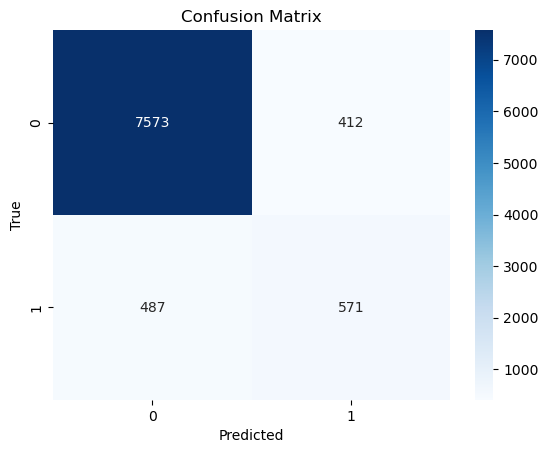

In [19]:
# 1. One-hot encode target for DL
y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)


#################################################################################
# 2. Build Deep Learning model
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']


    
#################################################################################
# 3. Train model
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)


#################################################################################
# 4. Evaluate model
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nTest Accuracy: {accuracy:.4f}")


#################################################################################
# 5. Classification report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print("\nClassification Report:, yes=1, no=0")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_enc.classes_]))

#################################################################################
# 6. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()